## MLS PRoject 2020 

### Slawomir Sowa
### G00375619@gmit.ie
---

### Subject:
In this project you must create a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to
produce a model that accurately predicts wind turbine power output from wind speed
values, as in the data set. You must then develop a web service that will respond with
predicted power values based on speed values sent as HTTP requests. Your submission
must be in the form of a git repository containing, at a minimum, the following items:
1. Jupyter notebook that trains a model using the data set. In the notebook you
should explain your model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model, as above.
3. Dockerfile to build and run the web service in a container.
4. Standard items in a git repository such as a README.

###  Wind Power Research

#### Fundmatental Equation of Wind Power
Wind Power depends on:
* amount of air (volume)
* speed of air (velocity)
* mass of air (density)

and the Wind Power can be calculated from 

$$P = \frac{1}{2} \rho Av^3  $$

Where: $\rho$ - density of the air, $A$ capture area of the wind, $v$ wind speed <em>[1]</em>

The most important variable is windspeed. The area swept out by of the turbine is a constant and the density of air is generally taken as $1.225 kg/m^3$, its value at sea level at 15 degrees $C$. <em>[2]</em>

The swept area can be calculated as:
$$ A = \pi r^2$$

![Swept Area](img/swept_area.png)

A German physicist Albert Betz concluded in 1919 that no wind turbine can convert more than 16/27 (59.3%) of the kinetic energy of the wind into mechanical energy turning a rotor. To this day, this is known as the Betz Limit or Betz' Law. The theoretical maximum power efficiency of any design of wind turbine is 0.59 (i.e. no more than 59% of the energy carried by the wind can
be extracted by a wind turbine). This is called the “power coefficient” and is defined as:

$$ C_{p_{max}} = 0.59$$

Also, wind turbines cannot operate at this maximum limit. The Cp value is unique to each turbine type and is a function of wind speed that the turbine is operating in. Once we incorporate various engineering requirements of a wind turbine - strength and durability in particular - the real world limit is well below the Betz Limit with values of 0.35-0.45 common even in the best designed wind turbines. <em>[1]</em>

$$ P_{avail} = \frac{1}{2} \rho Av^3 C_p $$

#### Turbine Output vs Winds Speed

The turbine starts producing power at about 3.5 $ m/s $ - the cut-in speed. Slower wind does not have enough power to keep the rotor turning. As the wind speed increases, there is a sharp increase in power. Shut_down speed is the speed at w
in which the turbine will apply a braking mechanism to prevent damage<em>[3]</em>. In this case it is about 24.5 $m/s$


![chart](img/turbine_chart.png)



### 1. Importing Libraries

In [1]:
# Import required librares 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# import joblib for saving models as pickle files [8]
import joblib

# import qqplot from statsmodels [5]
from statsmodels.graphics.gofplots import qqplot

# removes warnings from notebook [9]
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# If error: ModuleNotFoundError: No module named 'sklearn.linear_model.base'
# please uncoment and run code below to updated scikit-learn 

# !pip install scikit-learn --upgrade

### 2. Retrieve data

To import and read the dataset, I will use the Pandas library and use the read_csv method to read the columns into data frames.

In [3]:
# using pandas read_csv method to read data from file
df = pd.read_csv("powerproduction.csv")
df.head(15)


,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
df.tail(15)

,speed,power
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117
490,24.499,0.000
491,24.525,0.000
492,24.575,0.000
493,24.650,0.000
494,24.750,0.000


### 3. Data Preparation

This phase has three sub-phases:<br>
- data cleansing removes false values from the data source and inconsistencies in the acreoo data source,
- data integration enriches the data source by combining information from multiple data sources and
- data transformation ensures that the data is in a format suitable for use.

### Checking for missing values 

To check if any data is missing in the dataset, I used the <code>isnull()</code> function from the pandas library. The function returns Boolean True if null is present and False if null is not found. Pandas recognize an empty cell or NA as missing values.

In [5]:
df.isnull().any()

speed    False
power    False
dtype: bool

False result means that there are no missing values in our data.

But sometimes it might be the case where there’s missing values that have different formats than empty cell or N/A. For example it can be '--', 'na' or 'n/a'.
To find that kind of missing values we can use python code and iterate over a list of missing values.

In [6]:
# create a list of missing values
missing = ['--','-','na','n/a'] 

# test if values exist in our data frame
for i in missing:
    if i in df.values:
        print ('Missing values exist')
    else:
        print ('No missing values detected')

No missing values detected
No missing values detected
No missing values detected
No missing values detected


### 4. Data Exploration

In this part we will try to understand how variables interact with each other, the distribution of the
data, and whether there are outliers.<br>

Scatter plot shows relation between wind speed and power.

Text(0.5, 1.0, 'Wind Speed vs Output Power ')

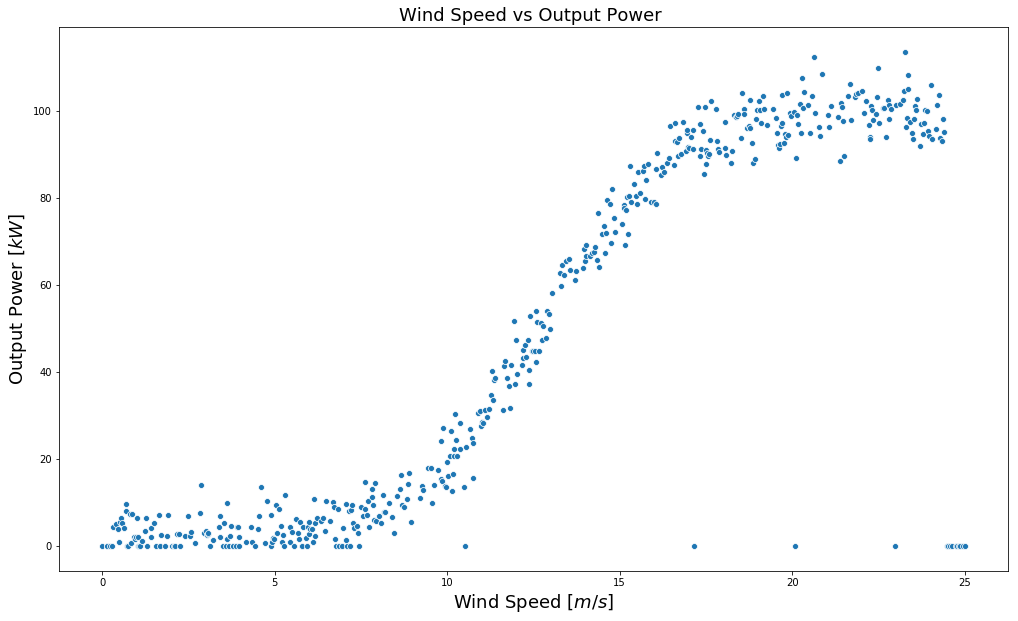

In [7]:
plt.figure(figsize=(17,10))
ax = sns.scatterplot(data=df, x="speed", y="power" )
ax.set_ylabel('Output Power', fontsize=22)
ax.set_xlabel('Wind Speed', fontsize=22)

ax.set_ylabel('Output Power $[kW]$', fontsize=18)
ax.set_xlabel('Wind Speed $[m/s]$', fontsize=18)
ax.set_title("Wind Speed vs Output Power ",fontsize=18 )

#### Removing outliers

From the scatter plot above we can see that we have values of power = 0 even with wind values higher than 3.25 $m/s$. This may mean that the turbine has stopped. These values should be removed from the data set.

In [8]:
df[df.power==0].count()

speed    49
power    49
dtype: int64

In [9]:
df_clean = df[df['power'] !=0]

Text(0.5, 1.0, 'Wind Speed vs Output Power cleaned ')

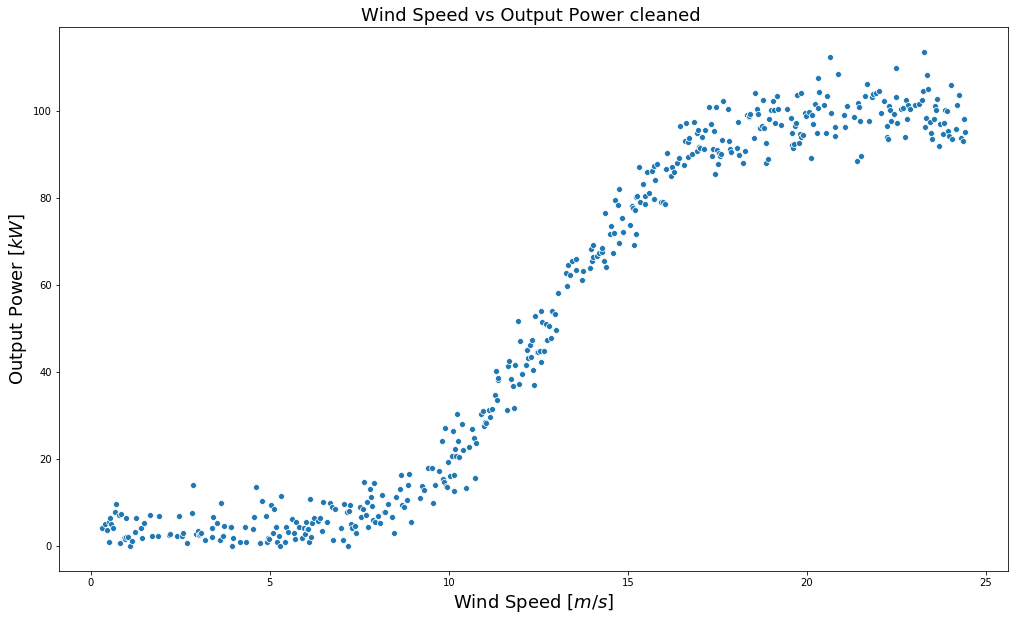

In [10]:
plt.figure(figsize=(17,10))
ax = sns.scatterplot(data=df_clean, x="speed", y="power" )
ax.set_ylabel('Output Power', fontsize=22)
ax.set_xlabel('Wind Speed', fontsize=22)

ax.set_ylabel('Output Power $[kW]$', fontsize=18)
ax.set_xlabel('Wind Speed $[m/s]$', fontsize=18)
ax.set_title("Wind Speed vs Output Power cleaned ",fontsize=18 )

#### Q-Q Test

The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a Normal or exponential. For example, if we run a statistical analysis that assumes our dependent variable is Normally distributed, we can use a Normal Q-Q plot to check that assumption. It’s just a visual check, not an air-tight proof, so it is somewhat subjective. But it allows us to see at-a-glance if our assumption is plausible, and if not, how the assumption is violated and what data points contribute to the violation.<em>[5]</em>

Text(0.5, 1.0, 'Q-Q Test - Power')

<Figure size 432x288 with 0 Axes>

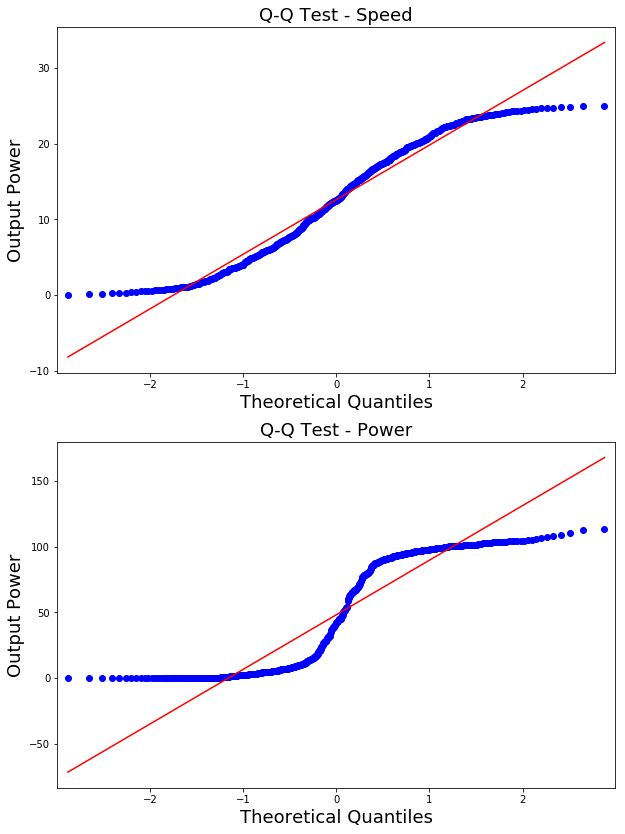

In [11]:
# Q-Q Plot
plt.figure()

fig, ax = plt.subplots(2,1, figsize=(10, 14))

# plot qq charts with data
qqplot(df['speed'],ax = ax[0], line='s', )
qqplot(df['power'],ax = ax[1], line='s', )


# set title and axis labels
ax[0].set_ylabel('Output Power', fontsize=18)
ax[0].set_xlabel('Theoretical Quantiles', fontsize=18)
ax[0].set_title('Q-Q Test - Speed',fontsize=18 )

ax[1].set_ylabel('Output Power', fontsize=18)
ax[1].set_xlabel('Theoretical Quantiles', fontsize=18)
ax[1].set_title('Q-Q Test - Power',fontsize=18)

As we can see that our Q-Q plot is not a straight line. Plot of that shape indicates that our data comes from Cumulative Distribution Function .


Text(0.5, 0, 'Output Power')

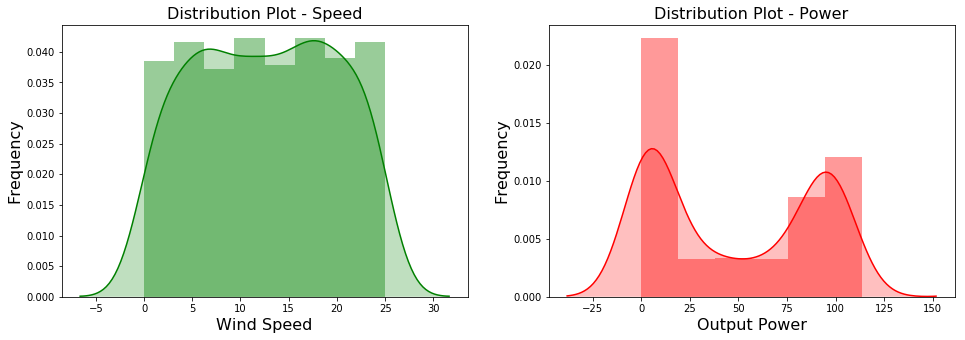

In [12]:
# Histogram Plots for speed and power

fig, axes = plt.subplots(1,2, figsize = (16,5))

axes[0].set_title('Distribution Plot - Speed',  fontsize='16')
axes[1].set_title('Distribution Plot - Power', fontsize='16')


sns.distplot(df['speed'], hist=True, color="g",  kde_kws={"shade": True}, ax = axes[0])
sns.distplot(df['power'], hist=True, color="r", kde_kws={"shade": True}, ax = axes[1])

axes[0].set_ylabel('Frequency', fontsize=16)
axes[1].set_ylabel('Frequency', fontsize=16)

axes[0].set_xlabel('Wind Speed', fontsize=16)
axes[1].set_xlabel('Output Power', fontsize=16)

#### Shapiro-Wilk Test
We've visually verified that <code>speed</code> and <code>power</code> are not Normally Distributed. <br> However, let's do the verification test using Shapiro-Wilk Test of normality.

>The tests assume that that the sample was drawn from a Gaussian distribution. Technically this is called the null hypothesis, or H0. A threshold level is chosen called alpha, typically 5% (or 0.05), that is used to interpret the p-value.<em>[6]</em>


In [13]:
# import shapiro() function from scipy.stats
from scipy.stats import shapiro

stat, p = shapiro(df['speed'])
print('Statistics=%.3f, p=%.15f' % (stat, p))


alpha = 0.05 
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.955, p=0.000000000032709
Sample does not look Gaussian (reject H0)


In [14]:
stat, p = shapiro(df['power'])
print('Statistics=%.3f, p=%.30f' % (stat, p))


alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.823, p=0.000000000000000000000045051657
Sample does not look Gaussian (reject H0)


Both tests failed, which means that our data are not Normally Distributed.

### Simple Linear Regression
Linear regression is probably one of the most important and widely used regression techniques. It’s among the simplest regression methods. One of its main advantages is the ease of interpreting results <em>[11]</em>.Is used to predict finite values of a series of numerical data. There is one independent variable x that is used to predict the variable y <em>[10]</em>

$$ y = b_0 + b_1x $$

A linear function has one independent variable and one dependent variable. The independent variable is $x$ and the dependent variable is $y$.
- $b_0$ is the constant term or the $y$ intercept. It is the value of the dependent variable when $x = 0$.
- $b_1$ is the coefficient of the independent variable. It is also known as the slope and gives the rate of change of the dependent variable.

#### Fitting a Linear Regression Model

In [15]:
# Code adapterd from:
# https://towardsdatascience.com/machine-learning-simple-linear-regression-with-python-f04ecfdadc13

# reshape data
X = df_clean["speed"].values.reshape(-1,1) 
y = df_clean["power"].values.reshape(-1,1) 

# splitting data for trains and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state=1) 
linReg_model = linear_model.LinearRegression()
linReg_model.fit(X_train, y_train)

# predicting on training data-set
y_train_predicted = linReg_model.predict(X_train)

# predicting on test data-set
y_test_predict = linReg_model.predict(X_test)


# evaluating the model on training dataset
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
r2_train = r2_score(y_train, y_train_predicted)

 # evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
r2_test = r2_score(y_test, y_test_predict)


print("The model performance for the training set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))

print("\n")

print("The model performance for the test set")
print("-------------------------------------------")
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))
print("\n")

print("-------------------------------------------")
print(f"Coefficients: {linReg_model.coef_[0][0]:.2f}" )
print(f'Intercept: {linReg_model.intercept_[0]:.2f}')


The model performance for the training set
-------------------------------------------
RMSE of training set is 12.840869370574996
R2 score of training set is 0.8999143665071773


The model performance for the test set
-------------------------------------------
RMSE of test set is 13.180861706974856
R2 score of test set is 0.8863631589082979


-------------------------------------------
Coefficients: 5.59
Intercept: -20.08


The value $b_0 = -20.08$ (approximately). The value $𝑏_1 = 5.59$ means that the predicted power rises by 5.59 when wind speed is increased by one.

Our estimated regression equation:
$$y = -20.08 + 5.59x $$

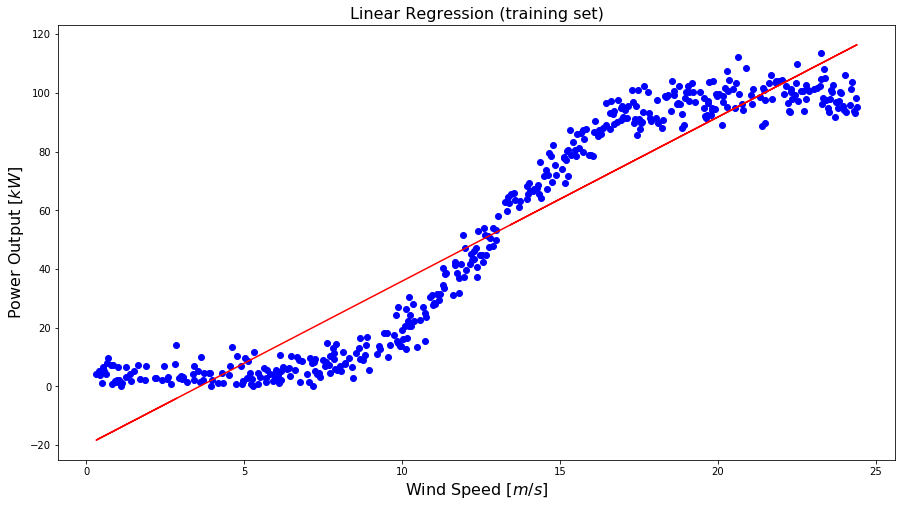

In [16]:
# Visualizing the Linear Regression model

plt.figure(figsize=(15,8))
plt.scatter(X, y, color='blue')
plt.plot(X_train, linReg_model.predict(X_train), color='red')
plt.title('Linear Regression (training set)',fontsize=16)
plt.xlabel('Wind Speed $[m/s]$',fontsize=16)
plt.ylabel('Power Output $[kW]$',fontsize=16)
plt.show()

In [17]:
# Prediction
wind = 20

# output power predicted from linear regression model
power = linReg_model.predict([[wind]])[0][0]

print(f"For a wind value of {wind} m/s, the power value predicted from the model is {power:.2f} kW")


For a wind value of 20 m/s, the power value predicted from the model is 91.80 kW


In [18]:
# saving linear regression model as .pkl file [8]  

# joblib.dump(linReg_model, "model/simple_linear_model.pkl")

print("File saved: 'model/simple_linear_model.pkl'")

File saved: 'model/simple_linear_model.pkl'


### Polynomial regression
Polynomial regression is a type of linear regression is often used to make predictions using polynomial powers of the independent variables <em>[10]</em>.

The polynomial models can be used in those situations where the relationship between study and explanatory
variables is curvilinear. Sometimes a nonlinear relationship in a small range of explanatory variable can also
be modelled by polynomials.

The $n^{th}$ order polynomial model in one variable is given by:

$$ y = b_0 + b_1x + b_2x^2 + b_3x^3 + ... + b_nx^n $$

The linear regression model $y=b_0 + b_1x$ includes the polynomieal regression model. Thus the techniques for fittin linear regression model can be used for fittin the polynomial regression model. 

The polynomial models can be used to approximate a complex non-linear relationship.<em>[12]</em> 

#### Train a model - Polynomial Regression

In [19]:
# Code adapted from:
# https://towardsdatascience.com/polynomial-regression-bbe8b9d97491


# reshape data
X = df_clean["speed"].values.reshape(-1,1) 
y = df_clean["power"].values.reshape(-1,1) 


# splitting data 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state=1)

# To convert the original features into their higher order terms we will use 
# the PolynomialFeatures class provided by scikit-learn. 
polynomial_features= PolynomialFeatures(degree=3,include_bias=False)
X_train_poly = polynomial_features.fit_transform(X_train)


# fit the transformed features to Linear Regression
poly_model = linear_model.LinearRegression()
poly_model.fit(X_train_poly, y_train)

# predicting on training data-set
y_train_predicted = poly_model.predict(X_train_poly)

# predicting on test data-set
y_test_predict = poly_model.predict(polynomial_features.fit_transform(X_test))

# evaluating the model on training dataset
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
r2_train = r2_score(y_train, y_train_predicted)

 # evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
r2_test = r2_score(y_test, y_test_predict)


print("The model performance for the training set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))

print("\n")

print("The model performance for the test set")
print("-------------------------------------------")
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))
print("\n")

print("-------------------------------------------")
print(f"Coefficients: {poly_model.coef_}" )
print(f'Intercept: {poly_model.intercept_}')


The model performance for the training set
-------------------------------------------
RMSE of training set is 5.958330903325327
R2 score of training set is 0.9784507517767205


The model performance for the test set
-------------------------------------------
RMSE of test set is 6.013444894445718
R2 score of test set is 0.976347436516299


-------------------------------------------
Coefficients: [[-10.57379334   1.55181622  -0.04066359]]
Intercept: [17.86824695]


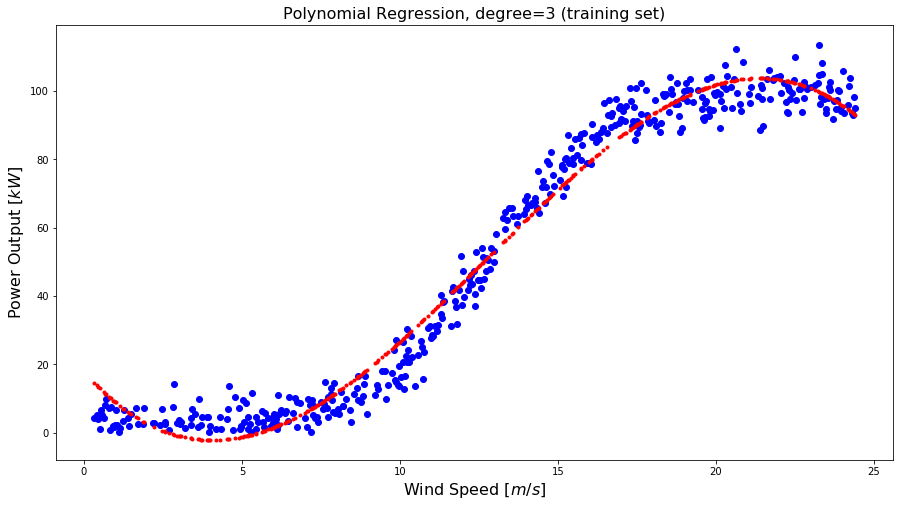

In [20]:
# Visualizing the Polynomial Regression model

plt.figure(figsize=(15,8))
plt.scatter(X, y, color='blue', label= "training data")
plt.plot(X_train, poly_model.predict(X_train_poly), "r.", label='Polynomial ')
plt.title('Polynomial Regression, degree=3 (training set)',fontsize=16)
plt.xlabel('Wind Speed $[m/s]$',fontsize=16)
plt.ylabel('Power Output $[kW]$',fontsize=16)
plt.show()

In [21]:
# Prediction 
speed = 20
power = poly_model.predict([[speed, speed ** 2, speed ** 3]])[0][0]

print(f"For a wind value of {wind} m/s, the power value predicted from the model is {power:.2f} kW")

For a wind value of 20 m/s, the power value predicted from the model is 101.81 kW


In [22]:
# saving linear regression model as .pkl file [8]  

# joblib.dump(poly_model, "model/polynomial_model.pkl")
print("File saved: 'model/polynomial_model.pkl'")

File saved: 'model/polynomial_model.pkl'


### Conclusions

The aim of the project was to analyze the data contained in the powerproduction.csv file, to train a model that would predict the power of the wind turbine depending on the wind speed.
I started by loading the data into the dataframe. Checking the null values and removing the zero power values.
To train the models, the data was divided into training set date and test set date.
Two models have been trained:
* With the use of linear regression - the obtained result for the training and test sets is surprisingly good. Although it is clear from the graph that our fit line does not match, the calculated $R^2$ is equal to $89.99\%$ for training set and and $88.63\%$ for test set. $R^2$ is a statistical measure of how close the data are to the fitted regression line, the closer the value of $R^2$ to 1, the better is the model fitted. Root Mean Squared Error is $12.84$ for the training set and $13.18$ for test set. RMSE is a measure of how well a regression line fits the data points.<br>

* With Polynomial regression - the obtained result for the training and test sets is better than with linear regression. From the graph it can be concluded that the curve with order = 3 will be the best fit. We got $R^2$ score of training set is $97.84\%$ and RMSE of training set is $5.96$, $R^2$ score of test set is $97.63\%$ and RMSE of test set is $6.01$. As we can see, the tele model fits the data better and with its use we are able to predict the power with better accuracy.

### References

<em>[1].</em> Wind Turbine Power Calculations;  https://www.raeng.org.uk/publications/other/23-wind-turbine <br>
<em>[2].</em> The Missing Link Between Air Density And Wind Power Production; https://www.technologyreview.com/2011/03/15/196333/the-missing-link-between-air-density-and-wind-power-production/<br>
<em>[3].</em> Rooftop Wind Turbines: Are They Worthwhile? https://www.engineering.com/ElectronicsDesign/ElectronicsDesignArticles/ArticleID/9556/Rooftop-Wind-Turbines-Are-They-Worthwhile.aspx<br>
<em>[4].</em> Ways to Detect and Remove the Outliers; https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba; May 22, 2018<br>
<em>[5].</em> Understanding Q-Q Plots; https://data.library.virginia.edu/understanding-q-q-plots/<br>
<em>[6].</em> https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/<br>
<em>[7].</em> Machine Learning: Simple Linear Regression with Python; https://towardsdatascience.com/machine-learning-simple-linear-regression-with-python-f04ecfdadc13<br>
<em>[8].</em> https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/<br>
<em>[9].</em> Remove warnings from jupyter notebook; https://stackoverflow.com/a/46721064<br>
<em>[10].</em> Polynomial Regression in Python – Complete Implementation in Python;  https://www.askpython.com/python/examples/polynomial-regression-in-python<br>
<em>[11].</em> Linear Regression in Python; https://realpython.com/linear-regression-in-python/<br>
<em>[12].</em> Chapter 12
Polynomial Regression Models http://home.iitk.ac.in/~shalab/regression/Chapter12-Regression-PolynomialRegression.pdf

